In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv').sort_values(['series_id', 'measurement_number'])

### Join train features with labels

In [3]:
train = pd.merge(train, labels, how='inner').sort_values(['series_id', 'measurement_number'])
print(train.shape)
display(train.head())
display(train.describe().T)

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


### Feature engineering

In [4]:
# def feat_eng(df):
#     df['totl_anglr_vel'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z'])** 0.5
#     df['totl_linr_acc'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z'])**0.5
#     df['totl_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z'])**0.5
#     df['acc_vs_vel'] = df['totl_linr_acc'] / df['totl_anglr_vel']

# feat_eng(train)
# feat_eng(test)

# train.fillna(0, inplace=True)
# test.fillna(0, inplace=True)

In [5]:
# def quaternion_to_euler(x, y, z, w):
#     import math
#     t0 = +2.0 * (w * x + y * z)
#     t1 = +1.0 - 2.0 * (x * x + y * y)
#     X = math.atan2(t0, t1)

#     t2 = +2.0 * (w * y - z * x)
#     t2 = +1.0 if t2 > +1.0 else t2
#     t2 = -1.0 if t2 < -1.0 else t2
#     Y = math.asin(t2)

#     t3 = +2.0 * (w * z + x * y)
#     t4 = +1.0 - 2.0 * (y * y + z * z)
#     Z = math.atan2(t3, t4)

#     return X, Y, Z


# def perform_feature_engineering(df):
#     x, y, z, w = df['orientation_X'].tolist(), df['orientation_Y'].tolist(), df['orientation_Z'].tolist(), df['orientation_W'].tolist()
#     nx, ny, nz = [], [], []
#     for i in range(len(x)):
#         xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
#         nx.append(xx)
#         ny.append(yy)
#         nz.append(zz)
    
#     df['euler_x'] = nx
#     df['euler_y'] = ny
#     df['euler_z'] = nz
    
#     df['total_angle'] = np.sqrt(np.square(df['euler_x']) + np.square(df['euler_y']) + np.square(df['euler_z']))
#     df['angle_vs_acc'] = df['total_angle'] / df['totl_linr_acc']
#     df['angle_vs_vel'] = df['total_angle'] / df['totl_anglr_vel']
    
# perform_feature_engineering(train)
# perform_feature_engineering(test)

In [6]:
# def mean_change_of_abs_change(x):
#         return np.mean(np.diff(np.abs(np.diff(x))))

# def mean_abs_change(x):
#     return np.mean(np.abs(np.diff(x)))

# def summarize_cols(df):
#     cols = df.columns
#     for col in cols:
#         if col in ['row_id', 'series_id', 'measurement_number', 'group_id', 'surface']:
#             continue
#         df[col + '_mean'] = df.groupby(['series_id'])[col].mean()
#         df[col + '_min'] = df.groupby(['series_id'])[col].min()
#         df[col + '_max'] = df.groupby(['series_id'])[col].max()
#         df[col + '_std'] = df.groupby(['series_id'])[col].std()
# #         df[col + '_mad'] = df.groupby(['series_id'])[col].mad()
# #         df[col + '_med'] = df.groupby(['series_id'])[col].median()
# #         df[col + '_skew'] = df.groupby(['series_id'])[col].skew()
#         df[col + '_max_to_min'] = df[col + '_max'] / df[col + '_min']
# #         df[col + '_mean_abs_change'] = df.groupby('series_id')[col].apply(mean_abs_change)
# #         df[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
# #         df[col + '_abs_max'] = df.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
# #         df[col + '_abs_min'] = df.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
# #         df[col + '_abs_mean'] = df.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(x)))
# #         df[col + '_abs_std'] = df.groupby('series_id')[col].apply(lambda x: np.std(np.abs(x)))

# old_cols = list(train.columns)
# summarize_cols(train)
# summarize_cols(test)
# add_cols = list(set(list(train.columns)) - set(old_cols))

In [7]:
# train.fillna(0, inplace = True)
# train.replace(-np.inf, 0, inplace = True)
# train.replace(np.inf, 0, inplace = True)
# test.fillna(0, inplace = True)
# test.replace(-np.inf, 0, inplace = True)
# test.replace(np.inf, 0, inplace = True)

### Turn data into series

In [8]:
def series_to_supervised(data, features, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data[features].shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in features]
    # Current timestep (t=0)
    cols.append(data)
    names += [(col) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [9]:
window = 3
features = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id']
use_cols = features + ['surface']
# Train
train_series = series_to_supervised(train[use_cols], features, window=window)
train_series.dropna(inplace=True)        
train_series = train_series[(train_series['series_id'] == train_series['series_id(t-%s)' % window])]
display(train_series.head())

# Test
test_series = series_to_supervised(test[features], features, window=window)
test_series.fillna(test_series.mean(), inplace=True)

# Backwards inputation
for index, row in test_series.iterrows():
    for i in range(1, window+1):
        if row['series_id'] != row['series_id(t-%s)' % i]:
            for feature in features:
                if feature != 'series_id':
                    test_series.at[index, '%s(t-%s)' % (feature, i)] = row[feature]
display(test_series.head())

,angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id,surface
3,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.0,0.067851,0.029939,0.003385,0.33995,1.50640,-9.4128,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960,0,fine_concrete
4,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0,fine_concrete
5,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0,fine_concrete
6,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0,fine_concrete
7,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.73497,-9.4296,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0,fine_concrete


,angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id
0,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.496095,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0
1,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.488284,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0
2,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.00000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.000000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0
3,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.00000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.000000,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0
4,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.000000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.00000,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0.000000,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,0


### Pre process the labels

In [10]:
n_labels =  train_series['surface'].nunique()
labels_names = train_series['surface'].unique()
le = LabelEncoder()
train_series['surface'] = le.fit_transform(train_series['surface'].values)

### Train/validation split

In [11]:
train_splited = []
val_splited = []
gp_surface = train.groupby(['surface', 'series_id'], as_index=False).count()[['surface', 'series_id']]
for surface in gp_surface['surface'].unique():
    df = gp_surface[gp_surface['surface'] == surface]
    tra, val = train_test_split(df, test_size=0.2, random_state=0)
    train_splited += list(tra['series_id'].values)
    val_splited += list(val['series_id'].values)
    
train_splited = pd.DataFrame(train_splited, columns=['series_id'])
val_splited = pd.DataFrame(val_splited, columns=['series_id'])

In [12]:
X_train = train_splited.merge(train_series)
X_val = val_splited.merge(train_series)

Y_train = X_train['surface']
Y_train = to_categorical(Y_train)
X_train.drop('surface', axis=1, inplace=True)
X_train = X_train

Y_val = X_val['surface']
Y_val = to_categorical(Y_val)
X_val.drop('surface', axis=1, inplace=True)
X_val = X_val

series_cols = list(X_train.filter(regex='series_id'))
X_train.drop(series_cols, axis=1, inplace=True)
X_val.drop(series_cols, axis=1, inplace=True)
test_series.drop(series_cols, axis=1, inplace=True)

print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (380500, 24)
Validation shape (95750, 24)


,angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0.028959,-0.011703,0.026238,0.032400,4.1378,-8.8985,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.035360,-0.032865,0.037684,0.16020,3.9802,-9.1033
1,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.09113,3.9570,-9.1022
2,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786
3,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.426570,4.0422,-9.0786,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355
4,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.426570,4.0422,-9.0786,0.034825,-0.020897,0.042671,0.139720,3.6555,-9.5355,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271


In [13]:
features = list(X_train.columns)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe().T)

Train shape (380500, 24)
Validation shape (95750, 24)


,count,mean,std,min,25%,50%,75%,max
angular_velocity_X(t-3),380500.0,0.000239,0.116873,-2.37100,-0.040808,0.000078,0.040634,2.2822
angular_velocity_Y(t-3),380500.0,0.008491,0.088018,-0.92786,-0.033364,0.005357,0.047895,1.0791
angular_velocity_Z(t-3),380500.0,-0.019517,0.226591,-1.26880,-0.090294,-0.005177,0.065491,1.3873
linear_acceleration_X(t-3),380500.0,0.128835,1.871720,-31.14200,-0.536833,0.123810,0.795283,36.7970
linear_acceleration_Y(t-3),380500.0,2.887363,2.103895,-82.75300,1.958700,2.879400,3.803100,55.9480
linear_acceleration_Z(t-3),380500.0,-9.364587,2.826003,-65.49200,-10.200000,-9.365800,-8.513100,65.8390
angular_velocity_X(t-2),380500.0,0.000206,0.116880,-2.37100,-0.040820,0.000069,0.040598,2.2822
angular_velocity_Y(t-2),380500.0,0.008493,0.087989,-0.92786,-0.033367,0.005351,0.047886,1.0791
angular_velocity_Z(t-2),380500.0,-0.019520,0.226574,-1.26880,-0.090311,-0.005202,0.065514,1.3873
linear_acceleration_X(t-2),380500.0,0.128704,1.872155,-31.14200,-0.536833,0.123670,0.795103,36.7970


### Scale the data

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_series)

In [15]:
subsequences = 2
timesteps = X_train.shape[1]//subsequences
X_train_series = X_train.reshape(X_train.shape[0], subsequences, (window+1), ((X_train.shape[1] // (window+1))//subsequences))
X_val_series = X_val.reshape(X_val.shape[0], subsequences, (window+1), ((X_val.shape[1] // (window+1))//subsequences))
X_test_series = X_test.reshape(X_test.shape[0], subsequences, (window+1), ((X_test.shape[1] // (window+1))//subsequences))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_val_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (380500, 2, 4, 3)
Validation set shape (95750, 2, 4, 3)
Test set shape (488448, 2, 4, 3)


### Model

In [16]:
epochs = 50
batch = 128
lr = 0.0001
adam = optimizers.Adam(lr)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series.shape[2], X_train_series.shape[3])))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(40, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 4, 64)       256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                27040     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 369       
Total params: 27,665
Trainable params: 27,665
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train_series, Y_train, validation_data=(X_val_series, Y_val), epochs=epochs, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 380500 samples, validate on 95750 samples
Epoch 1/50
 - 102s - loss: 1.9589 - val_loss: 1.8879
Epoch 2/50
 - 97s - loss: 1.8850 - val_loss: 1.8154
Epoch 3/50
 - 97s - loss: 1.8192 - val_loss: 1.7715
Epoch 4/50
 - 97s - loss: 1.7856 - val_loss: 1.7531
Epoch 5/50
 - 96s - loss: 1.7631 - val_loss: 1.7331
Epoch 6/50
 - 96s - loss: 1.7442 - val_loss: 1.7073
Epoch 7/50
 - 97s - loss: 1.7280 - val_loss: 1.6933
Epoch 8/50
 - 96s - loss: 1.7144 - val_loss: 1.6964
Epoch 9/50
 - 96s - loss: 1.7031 - val_loss: 1.6738
Epoch 10/50
 - 96s - loss: 1.6938 - val_loss: 1.6626
Epoch 11/50
 - 97s - loss: 1.6867 - val_loss: 1.6610
Epoch 12/50
 - 97s - loss: 1.6802 - val_loss: 1.6507
Epoch 13/50
 - 96s - loss: 1.6745 - val_loss: 1.6544
Epoch 14/50
 - 97s - loss: 1.6697 - val_loss: 1.6411
Epoch 15/50
 - 96s - loss: 1.6657 - val_loss: 1.6413
Epoch 16/50
 - 96s - loss: 1.6612 - val_loss: 1.6402
Epoch 17/50
 - 96s - loss: 1.6575 - val_loss: 1.6250
Epoch 18

#### Model loss plot

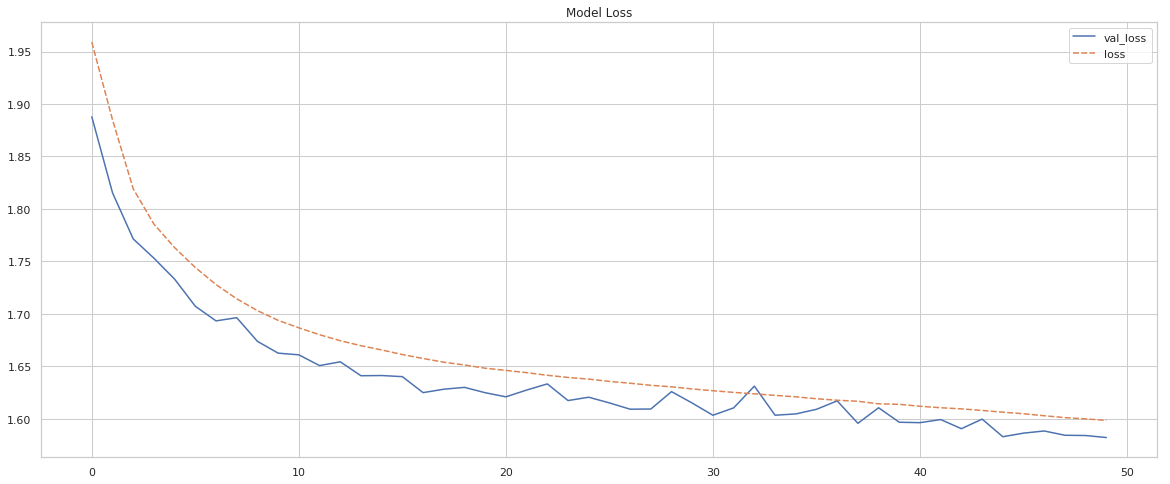

In [19]:
history_pd = pd.DataFrame.from_dict(history.history)
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [20]:
train_pred = model.predict_classes(X_train_series)
val_pred = model.predict_classes(X_val_series)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.41453876478318
Validation accuracy 0.41335770234986946


#### Model confusion matrix

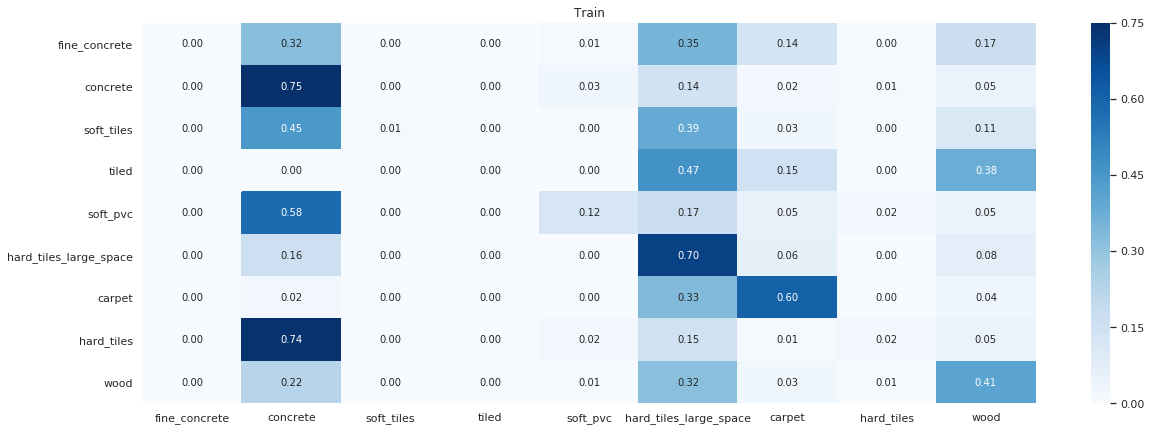

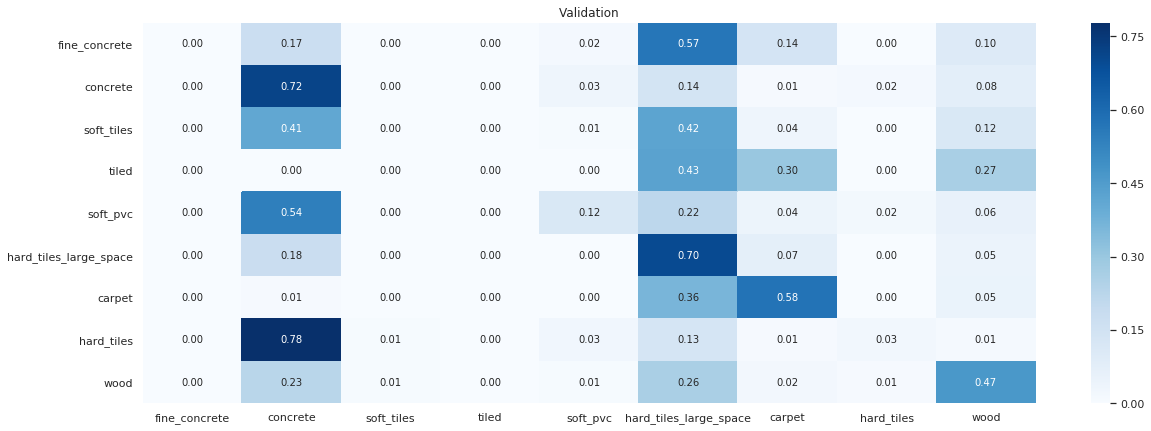

In [21]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [22]:
predictions = model.predict_classes(X_test_series)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)

,series_id,surface
0,0,concrete
1,1,soft_pvc
2,2,concrete
3,3,soft_pvc
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,soft_tiles
9,9,wood
